## Imports

In [1]:
from keras.regularizers import l1_l2
from keras.layers import BatchNormalization
from keras.layers import Bidirectional
from sklearn.utils import shuffle
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.constraints import max_norm
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error, r2_score
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam
import tensorflow as tf
from joblib import dump, load
from tensorflow.keras import losses
from astropy.coordinates import SkyCoord

# Input data

In [2]:
# Load the data
lightCurve = pd.read_csv("/Users/np699/Library/CloudStorage/OneDrive-DrexelUniversity/Untitled Folder/Forecaster/lightcurveDataCom7988.csv")
features = pd.read_csv("/Users/np699/Library/CloudStorage/OneDrive-DrexelUniversity/Untitled Folder/Forecaster/featureDataCom7988_pAstro.csv")

# Drop rows from lightCurve where 'simulation_id' is in [1624, 43162, 97688]
ids_to_drop = [1624, 43162, 97688]
lightCurve = lightCurve[~lightCurve['simulation_id'].isin(ids_to_drop)]

# Drop unnecessary columns from the features dataframe
features = features.drop(["simulation_id", 'far', 'snr'], axis=1)

# Filter the light curve data
filtered_df = lightCurve[lightCurve['filter'].isin(['ztfg', 'ztfr', 'ztfi'])].copy()
filtered_df = filtered_df[['filter', 'mag']]

num_light_curves = features.shape[0]

# Ensure the data is in the correct order
filter_order = ['ztfg', 'ztfr', 'ztfi']
filtered_df['filter'] = pd.Categorical(filtered_df['filter'], categories=filter_order, ordered=True)
filtered_df = filtered_df.sort_index()

# Consistency check
total_points = len(filtered_df)
num_time_points = total_points // (num_light_curves * len(filter_order))

# Reshape the data
y = np.empty((num_light_curves, num_time_points * len(filter_order)), dtype=filtered_df['mag'].dtype)
ztfg_mags = filtered_df[filtered_df['filter'] == 'ztfg']['mag'].values.reshape(num_light_curves, num_time_points)
ztfr_mags = filtered_df[filtered_df['filter'] == 'ztfr']['mag'].values.reshape(num_light_curves, num_time_points)
ztfi_mags = filtered_df[filtered_df['filter'] == 'ztfi']['mag'].values.reshape(num_light_curves, num_time_points)

# Populate reshaped array
for i in range(num_time_points):
    y[:, i * 3 + 0] = ztfg_mags[:, i]
    y[:, i * 3 + 1] = ztfr_mags[:, i]
    y[:, i * 3 + 2] = ztfi_mags[:, i]

# Time array
t_min = 0.1
t_max = 14.0
dt = 0.2
time_single = np.linspace(t_min, t_max, num_time_points)

# Standardize the feature data
feature_scaler = RobustScaler()
X = feature_scaler.fit_transform(features)
dump(feature_scaler, 'feature_scaler1.joblib')
# Standardize the target data
target_scaler = StandardScaler()
y = target_scaler.fit_transform(y)
dump(target_scaler, 'target_scaler1.joblib')
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Reshape y data for LSTM input
y_train_reshaped = y_train.reshape((y_train.shape[0], num_time_points, len(filter_order)))
y_test_reshaped = y_test.reshape((y_test.shape[0], num_time_points, len(filter_order)))

# Reshape X data for LSTM input
X_train_reshaped = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_reshaped = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Model

In [3]:
# Define the LSTM model
model = Sequential()

# First Bidirectional LSTM Layer with Batch Normalization and Dropout
model.add(Bidirectional(LSTM(150, activation='relu', return_sequences=True,
                             kernel_regularizer=l1_l2(l1=0.001, l2=0.01),
                             kernel_constraint=max_norm(3.0),
                        input_shape=(1, X_train.shape[1]))))
model.add(BatchNormalization())
model.add(Dropout(0.1))

# Second Bidirectional LSTM Layer with Batch Normalization
model.add(Bidirectional(LSTM(100, activation='relu', return_sequences=False,
                             kernel_regularizer=l1_l2(l1=0.001, l2=0.01),
                             kernel_constraint=max_norm(3.0)
                             )))
model.add(BatchNormalization())
model.add(Dropout(0.1))

# Dense output layer
model.add(Dense(213))

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


# Training

In [4]:
# Compile the model with a lower learning rate and gradient clipping
optimizer = Adam(learning_rate=0.0003, clipnorm=1.0)  # Only clipnorm is used
model.compile(optimizer=optimizer, loss='mse')

# Implement early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-6)

# Train the model
history = model.fit(X_train_reshaped, y_train, 
                    epochs=300, batch_size=64, validation_split=0.3, 
                    verbose=1, callbacks=[early_stopping, lr_reduction])

# Save the trained model
dump(model, 'LSTMpredLC1.joblib')

Epoch 1/300
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 18.0737 - val_loss: 12.8402 - learning_rate: 3.0000e-04
Epoch 2/300
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 11.1373 - val_loss: 8.0356 - learning_rate: 3.0000e-04
Epoch 3/300
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 6.6815 - val_loss: 4.8765 - learning_rate: 3.0000e-04
Epoch 4/300
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.8145 - val_loss: 2.9119 - learning_rate: 3.0000e-04
Epoch 5/300
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.0873 - val_loss: 1.7914 - learning_rate: 3.0000e-04
Epoch 6/300
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.1209 - val_loss: 1.2630 - learning_rate: 3.0000e-04
Epoch 7/300
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.7288 - val_loss: 1.0674 - learning_rate: 3.0000e-04
Epoch 8/300
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.6125 - val_loss: 0.9126 - learning_rate: 3.0000e-04
Epoch 9/300
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.5442 - val_loss: 0.7860 

['LSTMpredLC1.joblib']

# Predictions

(516312,)
()
Test MSE with MC Dropout: 0.3572, Test R² with MC Dropout: 0.6453
0.519080149857922


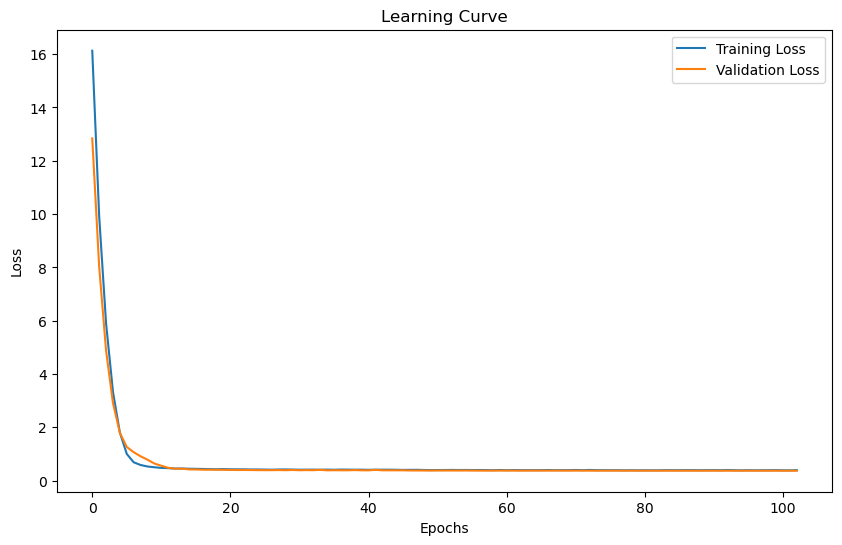

In [5]:
# MC Dropout function for prediction with uncertainty
def predict_with_uncertainty(model, X, n_iter=1000):
    """
    Perform MC Dropout predictions with TensorFlow 2.x.
    
    Args:
    - model: The Keras model with dropout layers.
    - X: Input data to make predictions on.
    - n_iter: Number of forward passes to perform.
    
    Returns:
    - mean_preds: Mean predictions.
    - uncertainty: Standard deviation of predictions (uncertainty).
    """
    
    # Perform n_iter forward passes and collect the predictions
    preds = [model(X, training=True) for _ in range(n_iter)]  # Dropout active during inference
    preds = np.array(preds)
    
    # Calculate mean and standard deviation of the predictions
    mean_preds = preds.mean(axis=0)
    uncertainty = preds.std(axis=0)
    
    return mean_preds, uncertainty

# Perform MC Dropout to predict with uncertainty
n_mc_samples = 1000  # Number of forward passes
mean_preds, uncertainty = predict_with_uncertainty(model, X_test_reshaped, n_iter=n_mc_samples)

# Reshape the mean predictions to match the shape used during scaling (num_samples, num_time_points * num_filters)
mean_preds_flat = mean_preds.reshape(mean_preds.shape[0], num_time_points * len(filter_order))  
# Invert the standardization for the mean predictions
mean_preds_inverted = target_scaler.inverse_transform(mean_preds_flat).reshape(mean_preds.shape[0], num_time_points, len(filter_order))

# Reshape uncertainty to match mean_preds_inverted shape
uncertainty_reshaped = uncertainty.reshape(uncertainty.shape[0], num_time_points, len(filter_order))
# Evaluate the model using the mean predictions
print(mean_preds_flat.flatten().shape)
test_mse_mc = mean_squared_error(y_test.flatten(), mean_preds_flat.flatten())
test_r2_mc = r2_score(y_test.flatten(), mean_preds_flat.flatten())
print(test_mse_mc.shape)
print(f'Test MSE with MC Dropout: {test_mse_mc:.4f}, Test R² with MC Dropout: {test_r2_mc:.4f}')
mae = np.mean(np.abs(y_test.flatten() - mean_preds_flat.flatten()))
print(mae)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Time points for plotting
time_points = np.tile(time_single, (X_test_reshaped.shape[0], 1))

# Invert the scaling for y_test to compare with predictions

y_test_inverted = target_scaler.inverse_transform(y_test.reshape(y_test.shape[0], -1)).reshape((y_test.shape[0], num_time_points, len(filter_order)))
mse_per_curve = np.mean((y_test_inverted - mean_preds_inverted) ** 2, axis=(1, 2))  # MSE for each light curve across all time points and filters

mse_target = 0.357
tolerance = 0.1  # Define a tolerance level to find light curves with MSE close to 3.6
selected_index = np.where(np.abs(mse_per_curve - mse_target) < tolerance)[0]  # Get the indices of the light curves that meet the condition

if len(selected_index) > 0:
    # Select the first light curve that matches the criteria
    example_idx = selected_index[0]

    # Step 3: Plot the selected light curve
    plt.figure(figsize=(10, 6))
    filter_names = ['ztfg', 'ztfr', 'ztfi']
    colors = {'ztfg': 'green', 'ztfr': 'red', 'ztfi': 'blue'}

    # Plot the ZTFg, ZTFr, and ZTFi filters separately for the selected light curve
    mean_curve = mean_preds_inverted[example_idx]
    true_curve = y_test_inverted[example_idx]

    # Loop over each filter
    for i, filter_name in enumerate(filter_names):
        plt.plot(time_single, mean_curve[:, i], label=f'Predicted {filter_name}', color=colors[filter_name])
        plt.fill_between(time_single, 
                         mean_curve[:, i] - 5 * uncertainty_reshaped[example_idx, :, i], 
                         mean_curve[:, i] + 5 * uncertainty_reshaped[example_idx, :, i], 
                         color=colors[filter_name], alpha=0.2, label=f'Uncertainty {filter_name}')

        # Plot the true values for comparison
        plt.plot(time_single, true_curve[:, i], '--', color=colors[filter_name], label=f'True {filter_name}')

    # Add labels and title
    plt.xlabel('Time (days)')
    plt.ylabel('Magnitude')
    plt.ylim(28, 20)  
    plt.xlim(0, 6) 
    #plt.gca().invert_yaxis()  # Invert the y-axis for magnitude, since lower magnitude means brighter
    #plt.title(f'Light Curve with MSE ~ {mse_target} (Light Curve Index: {example_idx})')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print(f"No light curve found with MSE close to {mse_target}.")

TypeError: object of type 'int' has no len()

Filter: ztfg, MSE at peak shape: (2424,)


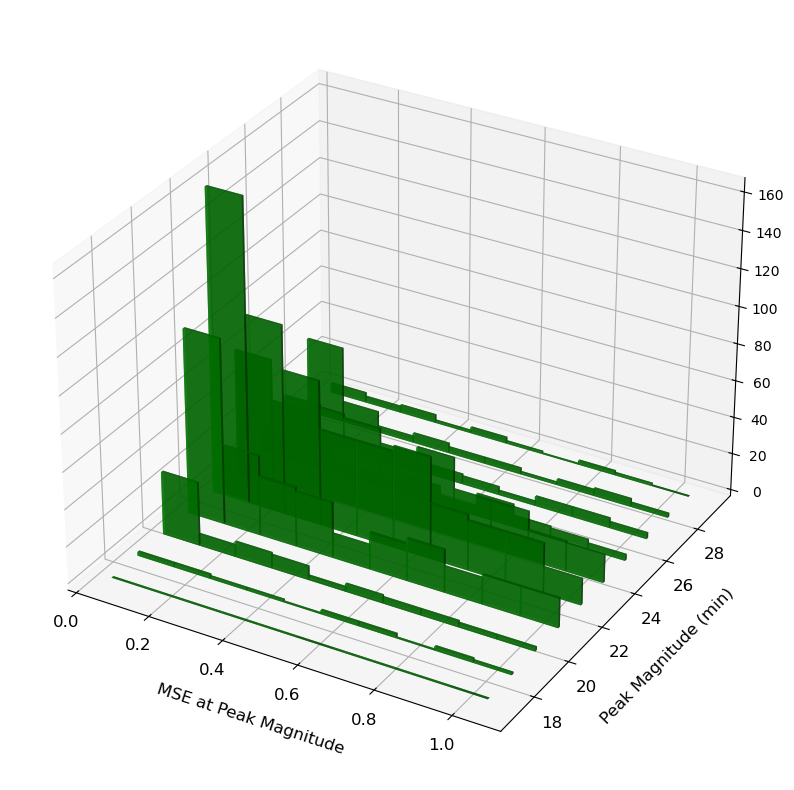

Filter: ztfr, MSE at peak shape: (2424,)


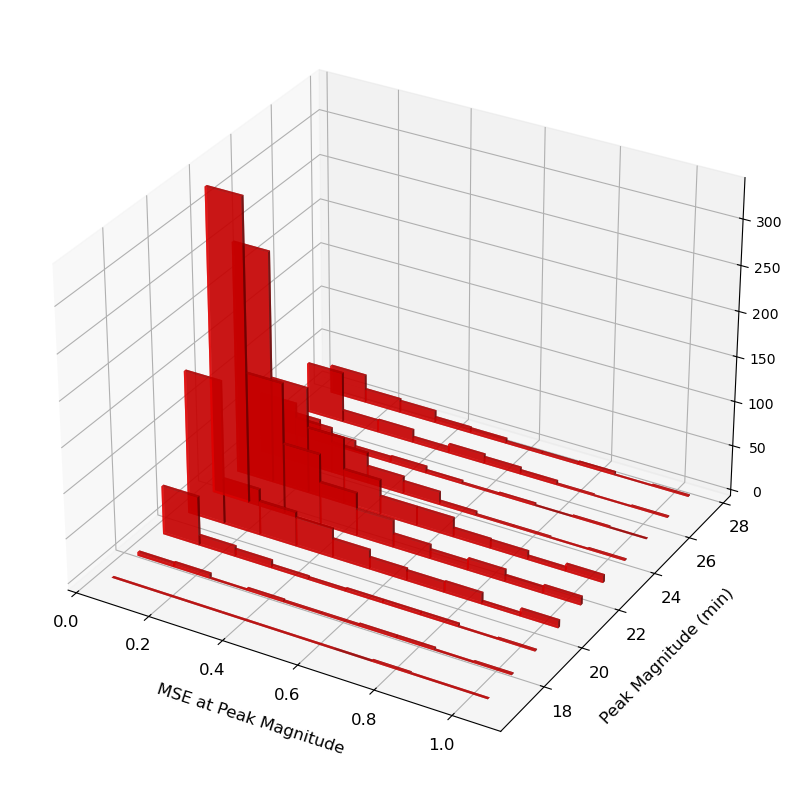

Filter: ztfi, MSE at peak shape: (2424,)


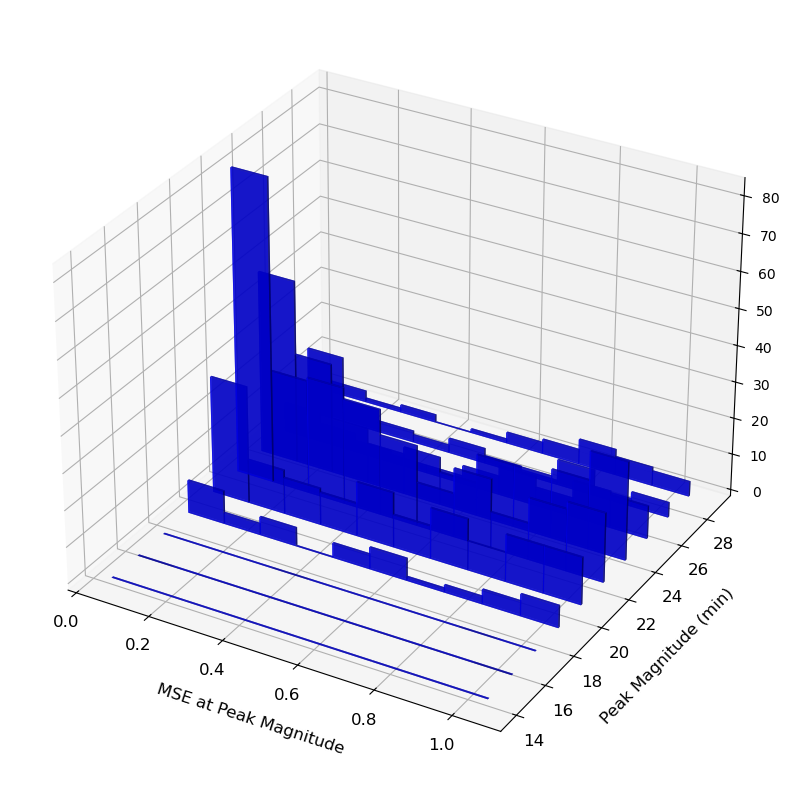

In [7]:
for i, filter_name in enumerate(filter_names):
    # Step 1: Calculate the index of the minimum value (peak magnitude) for the current filter
    peak_indices = np.argmin(y_test_inverted[:, :, i], axis=1)  # Shape (num_samples,)

    # Step 2: Extract the corresponding predicted values at the peak magnitude indices
    peak_preds_filter = mean_preds_inverted[np.arange(mean_preds_inverted.shape[0]), peak_indices, i]

    # Step 3: Extract the corresponding true values at the peak magnitude indices
    peak_true_filter = y_test_inverted[np.arange(y_test_inverted.shape[0]), peak_indices, i]

    # Step 4: Calculate the MSE at the peak magnitude for each light curve
    mse_at_peak_filter = (peak_true_filter - peak_preds_filter) ** 2  # Shape (num_samples,)

    # Print the shapes to verify
    print(f"Filter: {filter_name}, MSE at peak shape: {mse_at_peak_filter.shape}")
    
    # Step 5: Now you can create histograms or perform further analysis based on mse_at_peak_filter
    fig = plt.figure(figsize=(12, 10))  # Increased figure size
    ax = fig.add_subplot(111, projection='3d')

    # Create a 3D histogram for the current filter
    hist, xedges, yedges = np.histogram2d(
        mse_at_peak_filter, peak_true_filter, bins=10,
        range=[[0, 1], [np.min(peak_true_filter), np.max(peak_true_filter)]]
    )

    # Construct arrays for the 3D histogram bars
    xpos, ypos = np.meshgrid(
        xedges[:-1] + 0.5 * (xedges[1:] - xedges[:-1]),
        yedges[:-1] + 0.5 * (yedges[1:] - yedges[:-1]),
        indexing="ij"
    )

    xpos = xpos.ravel()
    ypos = ypos.ravel()
    zpos = 0

    # Set the width and depth for the bars
    dx = dy = 0.1 * np.ones_like(zpos)
    dz = hist.ravel()

    # Plot the bars
    ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average', color=colors[filter_names[i]], alpha=0.7)

    # Set labels and title
    ax.set_xlabel('MSE at Peak Magnitude', fontsize=12, labelpad=10)
    ax.set_ylabel('Peak Magnitude (min)', fontsize=12, labelpad=10)
    ax.set_zlabel('Number of Light Curves', fontsize=12, labelpad=10)
    #ax.set_title(f'3D Histogram of MSE vs Number of Light Curves vs Peak Magnitude for {filter_name}')
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    plt.savefig(f'3DHist_{filter_name}.png')
   

    plt.show()
    

(2424, 71, 3)
(2424, 71, 3)


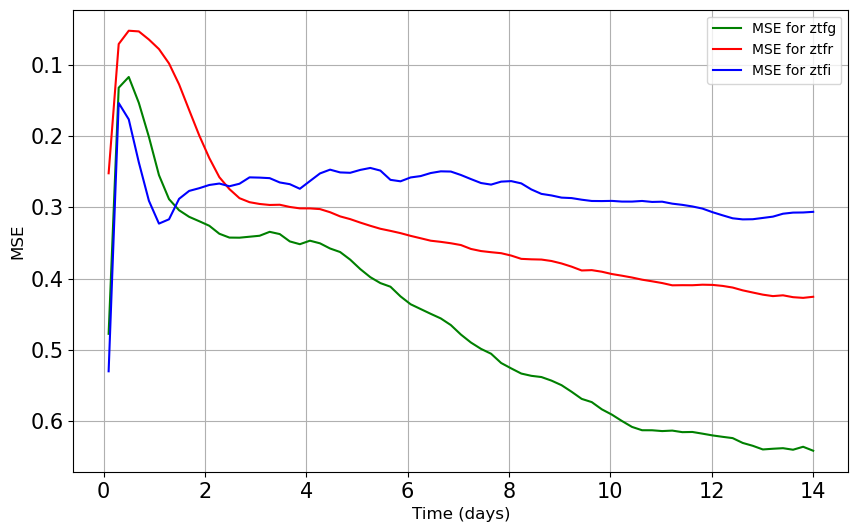

{'ztfg': 0.4662578589163498,
 'ztfr': 0.3262258837284734,
 'ztfi': 0.27919891207183295}

In [8]:
# Loop over each filter and compute MSE at each time step
mse_vs_time = {}
filter_names = ['ztfg', 'ztfr', 'ztfi']
colors = {'ztfg': 'green', 'ztfr': 'red', 'ztfi': 'blue'}
y_test_reshaped = y_test.reshape(y_test.shape[0], num_time_points, len(filter_order)) 
print(y_test_reshaped.shape)
mean_preds_reshaped = mean_preds.reshape(mean_preds.shape[0], num_time_points, len(filter_order)) 
print(mean_preds_reshaped.shape)
for i, filter_name in enumerate(filter_names):
    # Calculate MSE at each time step (averaged across all light curves)
    mse_per_time_step = np.mean((y_test_reshaped[:,:,i] - mean_preds_reshaped[:,:,i]) ** 2, axis=0)  
    
    mse_vs_time[filter_name] = mse_per_time_step

plt.figure(figsize=(10, 6))

for filter_name in filter_names:
    plt.plot(time_single, mse_vs_time[filter_name], label=f'MSE for {filter_name}', color=colors[filter_name])

# Add labels and title
plt.xlabel('Time (days)', fontsize = 12)
plt.ylabel('MSE', fontsize = 12)
#plt.title('MSE vs Time Step for Each Filter')
plt.legend()
plt.grid(True)
plt.gca().invert_yaxis() 
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()
average_mse_per_filter = {filter_name: np.mean(mse_vs_time[filter_name]) for filter_name in filter_names}

average_mse_per_filter

# Predicted LC for O4a condidates

In [9]:
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from joblib import load

# Load the saved model
model = load('/Users/np699/Library/CloudStorage/OneDrive-DrexelUniversity/Untitled Folder/Forecaster/BNS-NSBH-Regressor/LSTMpredLC1.joblib')
new_features = pd.read_csv("/Users/np699/Library/CloudStorage/OneDrive-DrexelUniversity/Untitled Folder/Forecaster/featureO4a1.csv")
# Time array
t_min = 0.1
t_max = 14.0
num_time_points = 71  # Adjusted based on the actual number of time points
dt = 0.2
time_single = np.linspace(t_min, t_max, num_time_points)
filter_order = 3
# Standardize the new feature data
feature_scaler = load('/Users/np699/Library/CloudStorage/OneDrive-DrexelUniversity/Untitled Folder/Forecaster/BNS-NSBH-Regressor/feature_scaler1.joblib')
X_new = feature_scaler.transform(new_features)
print(X_new.shape)

# Reshape X data for LSTM input based on the model's input shape (1 timestep, 7 features)
X_new_reshaped = X_new.reshape((X_new.shape[0], 1, X_new.shape[1]))

# Function to perform MC Dropout predictions
def predict_with_uncertainty(model, X, n_iter=1000):
    preds = [model(X, training=True) for _ in range(n_iter)]  # Dropout active during inference
    preds = np.array(preds)
    mean_preds = preds.mean(axis=0)
    uncertainty = preds.std(axis=0)
    return mean_preds, uncertainty

# Perform MC Dropout to predict with uncertainty
n_mc_samples = 1000  # Number of forward passes
mean_preds, uncertainty = predict_with_uncertainty(model, X_new_reshaped, n_iter=n_mc_samples)
print(mean_preds.shape)
# Reshape the mean predictions to match the shape used during scaling (num_samples, num_time_points * num_filters)
mean_preds_flat = mean_preds.reshape(mean_preds.shape[0], num_time_points * 3)  # Shape (num_samples, num_time_points * num_filters)
print(mean_preds_flat.shape)
# Invert the standardization for the mean predictions
mean_preds_inverted = target_scaler.inverse_transform(mean_preds_flat).reshape(mean_preds.shape[0], num_time_points, 3)
print(mean_preds_inverted.shape)

# Reshape uncertainty to match mean_preds_inverted shape
uncertainty_reshaped = uncertainty.reshape(uncertainty.shape[0], num_time_points, 3)
# Invert the normalization for the mean predictions
#mean_preds_inverted = (mean_preds_new * y_std) + y_mean
#mean_preds_inverted = mean_preds_inverted.reshape(mean_preds_new.shape[0], num_time_points, 3)


# Plotting function for all 7 light curves with uncertainty and print min values
def plot_all_light_curves_with_uncertainty_and_min(time_array, mean_preds, uncertainty, num_examples=8):
    # Define colors for plotting
    colors = {'ztfg': 'green', 'ztfr': 'red', 'ztfi': 'blue'}

    # Time array for plotting (using `time_single` from earlier)
    time_single = time_array

    # Filter names for ZTF filters
    filter_names = ['ztfg', 'ztfr', 'ztfi']

    # Loop through all examples (7 examples in this case)
    for example_idx in range(num_examples):
        # Select one example light curve to plot
        mean_curve_new = mean_preds_inverted[example_idx]
        uncertainty_curve_new = uncertainty[example_idx]

        # Create a plot for the predicted light curve and uncertainty
        plt.figure(figsize=(10, 6))
        
        # To store min values for each filter
        min_values = {}
        min_values_un = {}

        for i in range(3):  # 3 filters
            # Plot the mean predicted light curve
            plt.plot(time_single, mean_curve_new[:, i], label=f'Predicted {filter_names[i]}', color=colors[filter_names[i]])
            plt.fill_between(time_single, 
                             mean_curve_new[:, i] - 5 * uncertainty_curve_new[:, i], 
                             mean_curve_new[:, i] + 5 * uncertainty_curve_new[:, i], 
                             color=colors[filter_names[i]], alpha=0.2)

            # Find and print the minimum value of the current filter's light curve
            min_value = np.min(mean_curve_new[:, i])
            min_values[filter_names[i]] = min_value

            # Find the minimum uncertainty value of the current filter's light curve
            min_value_un = np.min(uncertainty_curve_new[:, i])
            min_values_un[filter_names[i]] = min_value_un

        # Display min values
        print(f"Example {example_idx + 1}: Min values of light curves:")
        for filter_name, min_value in min_values.items():
            print(f"  {filter_name}: {min_value}")
        
        print(f"Example {example_idx + 1}: Min values of uncertainty:")
        for filter_name, min_value_un in min_values_un.items():
            print(f"  {filter_name}: {min_value_un}")

        # Plot settings
        plt.xlabel('Time (days)')
        plt.ylabel('Magnitude')
        plt.gca().invert_yaxis()  # Invert the y-axis for magnitude
        plt.title(f'Predicted Light Curve with Uncertainty (Example {example_idx + 1})')
        plt.legend()
        plt.ylim(26, 10)  
        plt.xlim(0, 6) 
        plt.show()

# Plot all 7 light curves with uncertainty and print min values
plot_all_light_curves_with_uncertainty_and_min(time_single, mean_preds_inverted, uncertainty_reshaped, num_examples=8)

import csv

# Function to save light curves with uncertainty to a CSV file
def save_light_curves_to_csv(time_array, mean_preds, uncertainty, num_examples=8, output_file='light_curves_with_uncertainty.csv'):
    # Prepare a list to store the CSV rows
    csv_data = []

    # Filter names for ZTF filters
    filter_names = ['ztfg', 'ztfr', 'ztfi']

    # Loop through all examples (7 examples in this case)
    for example_idx in range(num_examples):
        mean_curve_new = mean_preds_inverted[example_idx]
        uncertainty_curve_new = uncertainty[example_idx]

        # For each time step and filter, store time, magnitude, and uncertainty
        for i in range(num_time_points):
            for j in range(3):  # 3 filters: ztfg, ztfr, ztfi
                csv_data.append({
                    'Example': example_idx + 1,
                    'Time (days)': time_array[i],
                    'Filter': filter_names[j],
                    'Magnitude': mean_curve_new[i, j],
                    'Uncertainty': uncertainty_curve_new[i, j]
                })

    # Convert the list of dictionaries to a DataFrame
    df = pd.DataFrame(csv_data)

    # Save to CSV file
    df.to_csv(output_file, index=False)
    print(f"Data saved to {output_file}")

# Call the function to save the data
save_light_curves_to_csv(time_single, mean_preds_inverted, uncertainty_reshaped, num_examples=8, output_file='light_curves_with_uncertainty.csv')

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Latitude
- Longitude
Feature names seen at fit time, yet now missing:
- PAstro
- latitude
- longitude


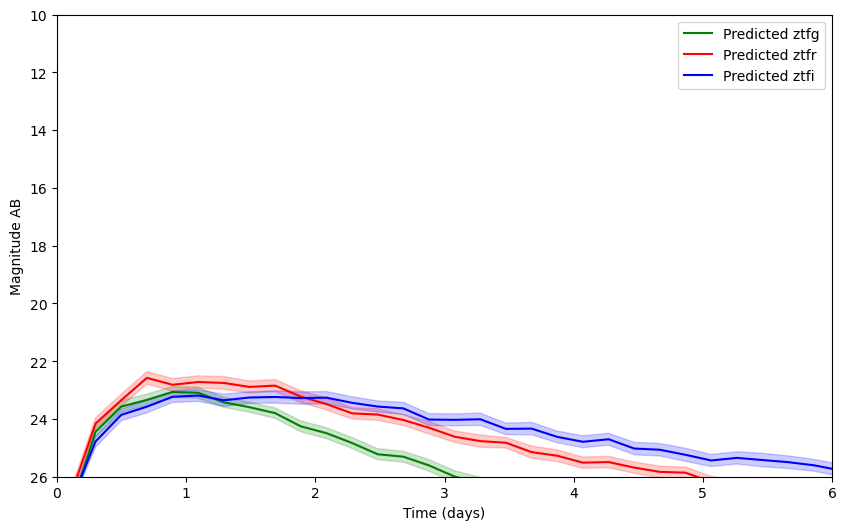

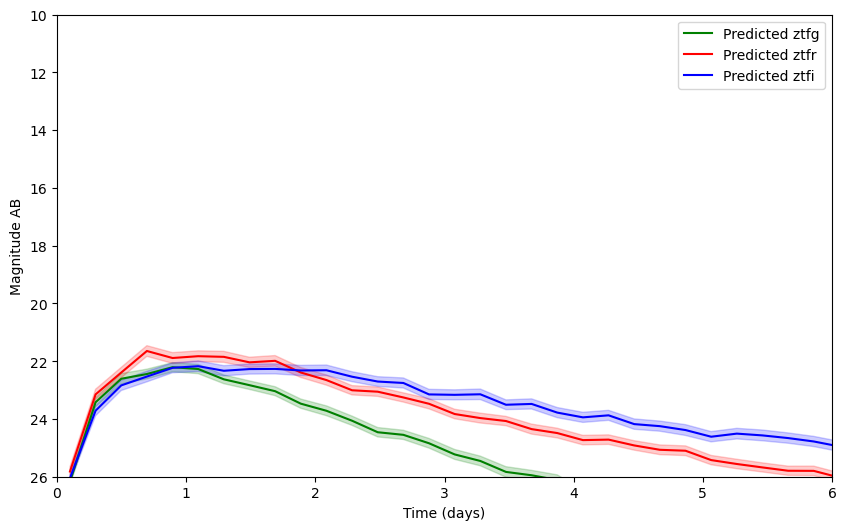

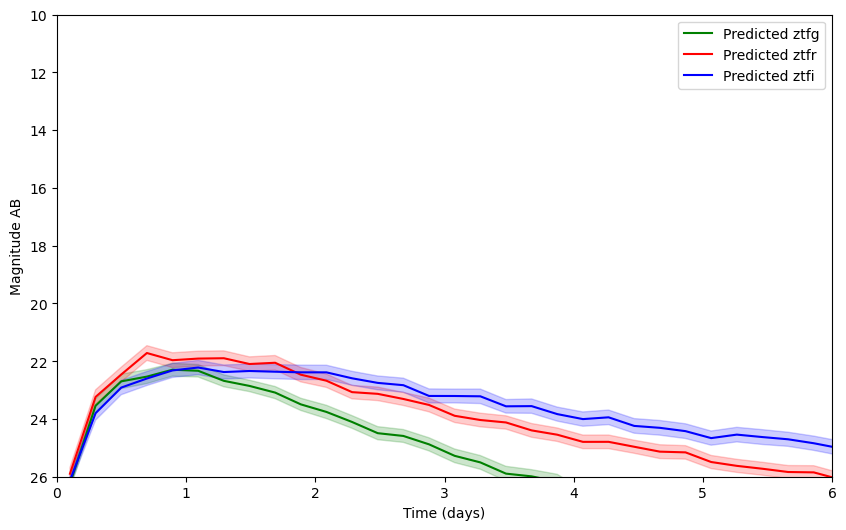

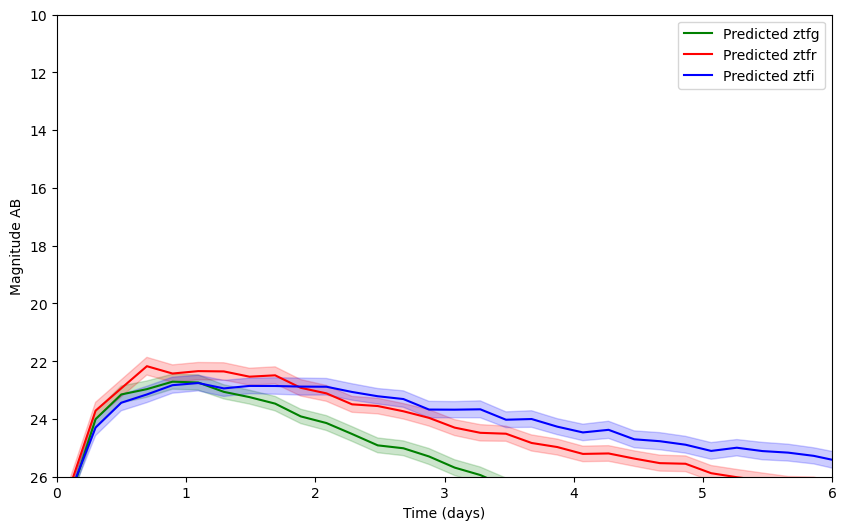

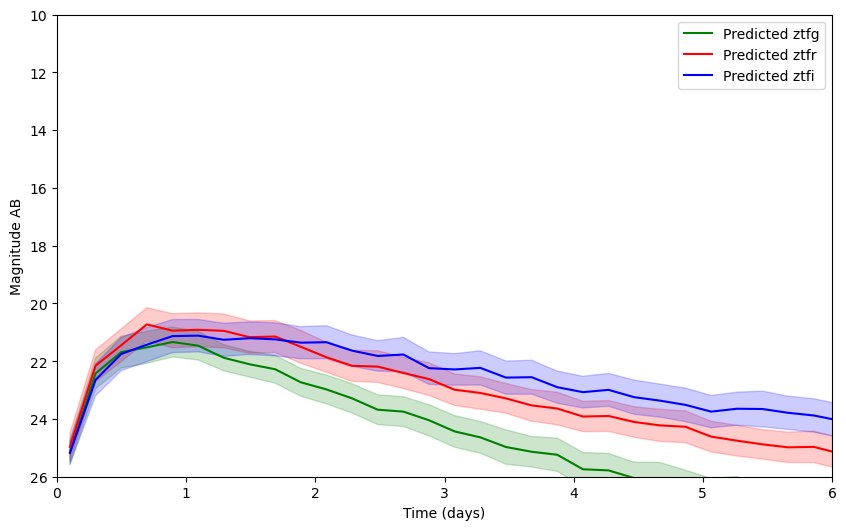

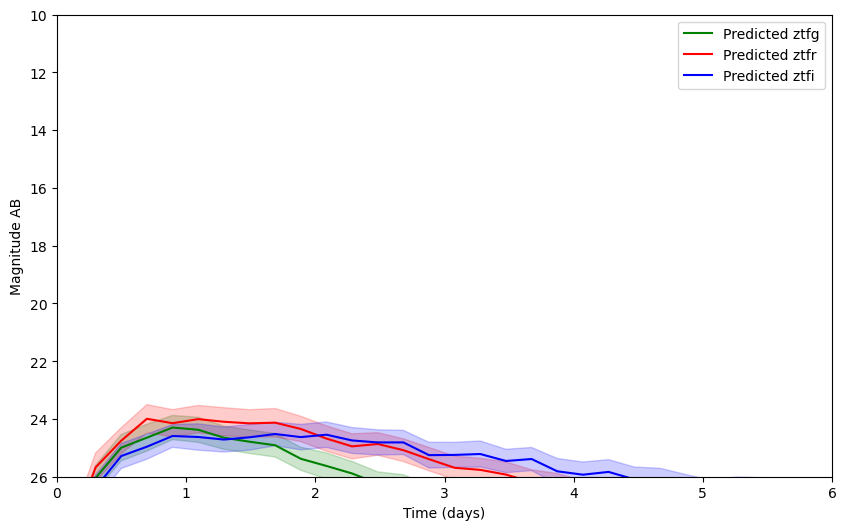

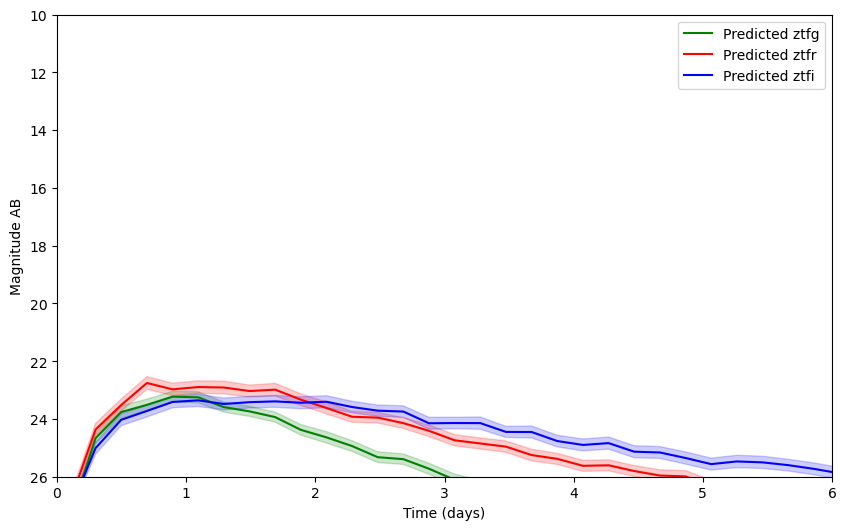

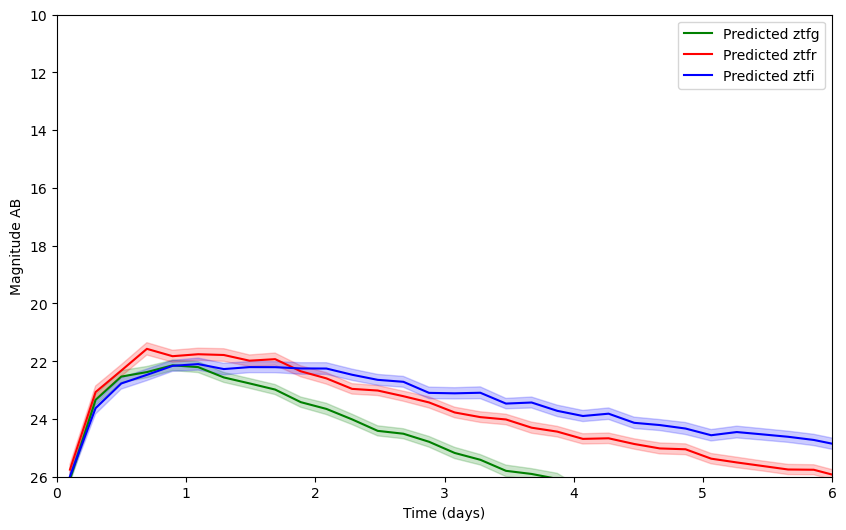

In [12]:
def plot_all_light_curves_with_uncertainty_and_min(time_array, mean_preds, uncertainty):
    # Define colors for plotting
    colors = {'ztfg': 'green', 'ztfr': 'red', 'ztfi': 'blue'}

    # Time array for plotting
    time_single = time_array

    # Filter names for ZTF filters
    filter_names = ['ztfg', 'ztfr', 'ztfi']

    # Determine the number of examples from mean_preds
    num_examples = len(mean_preds)

    # Loop through all available examples
    for example_idx in range(num_examples):
        # Select one example light curve to plot
        mean_curve_new = mean_preds[example_idx]
        uncertainty_curve_new = uncertainty[example_idx]

        # Create a plot for the predicted light curve and uncertainty
        plt.figure(figsize=(10, 6))

        for i in range(3):  # 3 filters
            # Plot the mean predicted light curve
            plt.plot(time_single, mean_curve_new[:, i], label=f'Predicted {filter_names[i]}', color=colors[filter_names[i]])
            plt.fill_between(time_single, 
                             mean_curve_new[:, i] - 5 * uncertainty_curve_new[:, i], 
                             mean_curve_new[:, i] + 5 * uncertainty_curve_new[:, i], 
                             color=colors[filter_names[i]], alpha=0.2)

        # Plot settings
        plt.xlabel('Time (days)')
        plt.ylabel('Magnitude AB')
        plt.gca().invert_yaxis()  # Invert the y-axis for magnitude
        plt.legend()
        plt.ylim(26, 10)  
        plt.xlim(0, 6) 
        plt.show()

plot_all_light_curves_with_uncertainty_and_min(time_single, mean_preds_inverted, uncertainty_reshaped)

/opt/anaconda3/lib/python3.11/site-packages/ligo/lw/lsctables.py:89: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal


S250104v 2025-01-04T01:51:22
superevent_id: S250104v, alert_type: Update, significant: 1, group: CBC, prob_bns: 1.8544833063307938e-19, prob_nsbh: 1.4617120326600948e-09, prob_ter: 1.7373746993287753e-06, prob_bbh: 0.9999982611635887, distmean: 4931.659285813638
[[1.51436113e+03 4.93165929e+03 1.17573633e+00 7.52380833e-01
  0.00000000e+00 0.00000000e+00 6.33436853e-03 9.99998263e-01]]
[[-9.27796210e-02  1.47317866e+01 -6.13873052e-01  6.43997083e-01
  -1.00000000e+00 -1.00000000e+00  6.33436853e-03  4.38669376e-02]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

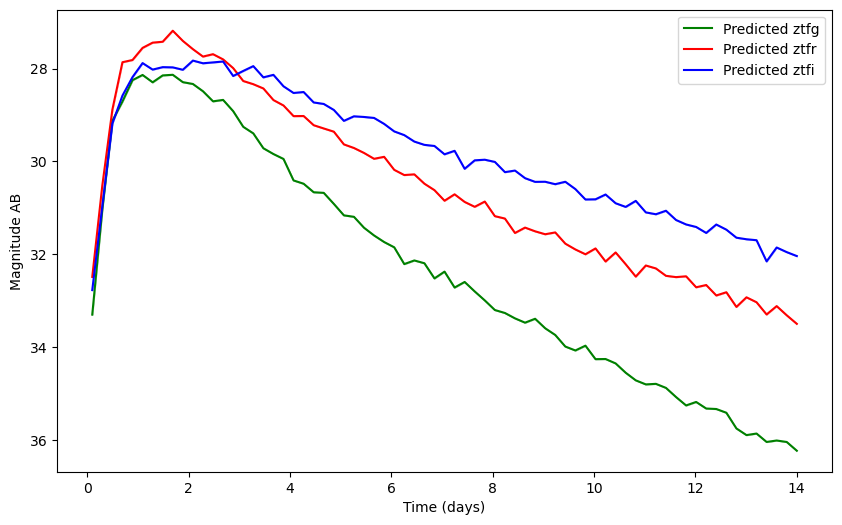

S250108eo 2025-01-08T15:22:22
superevent_id: S250108eo, alert_type: Update, significant: 1, group: CBC, prob_bns: 0.0, prob_nsbh: 5.361578768907928e-13, prob_ter: 2.581825509762048e-05, prob_bbh: 0.9999741817443663, distmean: 4305.697402078388
[[ 7.94915994e+02  4.30569740e+03  6.15181978e+00 -1.11884332e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  9.99974182e-01]]
[[-0.15458842 12.72157035  0.9457135  -0.99729513 -1.         -1.
   0.          0.04377969]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1

KeyboardInterrupt: 

%4|1738337517.335|MAXPOLL|rdkafka#consumer-1| [thrd:main]: Application maximum poll interval (300000ms) exceeded by 16ms (adjust max.poll.interval.ms for long-running message processing): leaving group
%6|1738340228.145|FAIL|rdkafka#consumer-1| [thrd:sasl_ssl://kafka.gcn.nasa.gov:9092/bootstrap]: sasl_ssl://kafka.gcn.nasa.gov:9092/bootstrap: Disconnected (after 31ms in state AUTH_HANDSHAKE)
%3|1738340228.145|FAIL|rdkafka#consumer-1| [thrd:sasl_ssl://kafka.gcn.nasa.gov:9092/bootstrap]: sasl_ssl://kafka.gcn.nasa.gov:9092/bootstrap: SASL OAUTHBEARER mechanism handshake failed: Local: Broker transport failure: broker's supported mechanisms: (n/a) (after 0ms in state DOWN)
%6|1738340587.981|FAIL|rdkafka#consumer-1| [thrd:sasl_ssl://kafka1.gcn.nasa.gov:9092/1]: sasl_ssl://kafka1.gcn.nasa.gov:9092/1: Disconnected (after 23ms in state AUTH_HANDSHAKE)
%3|1738340587.981|FAIL|rdkafka#consumer-1| [thrd:sasl_ssl://kafka1.gcn.nasa.gov:9092/1]: sasl_ssl://kafka1.gcn.nasa.gov:9092/1: SASL OAUTHBEARER 

In [1]:
import pickle
from gcn_kafka import Consumer
import astropy_healpix as ah
import numpy as np
import pandas as pd
import astropy.cosmology as cos
from sklearn.neural_network import MLPRegressor
from astropy.cosmology import Planck15 as cosmo
from astropy.table import Table
import astropy.units as u
import requests
from io import BytesIO
import matplotlib.pyplot as plt
from astropy.time import Time
import healpy as hp
import xmltodict
from ligo.skymap.io import read_sky_map
from astropy.io import fits
from astropy.coordinates import SkyCoord
from ligo.skymap.postprocess import find_greedy_credible_levels
from joblib import load
from sklearn.preprocessing import StandardScaler

config = {'group.id': 'bnsAndnsbhLCforslack',
          'auto.offset.reset': 'earliest',
          'enable.auto.commit': False}

# Connect as a consumer (client "Natalya Pletskova")
consumer = Consumer(config=config,
                    client_id='3ipd76gggl9edibth02eb2feag',
                    client_secret='mhl631h2hobaj0uc4d5dbr08qvp7l4fhnudjeh5mq9ja8m3vujb',
                    domain='gcn.nasa.gov')

consumer.subscribe(['gcn.classic.voevent.LVC_PRELIMINARY',
                    'gcn.classic.voevent.LVC_INITIAL',
                    'gcn.classic.voevent.LVC_UPDATE'])

sent_messages = set()
def parse_gcn(response):
    dict=xmltodict.parse(response)
    return (dict)
    
def get_params(event_dict):
    superevent_id = [item['@value'] for item in event_dict['voe:VOEvent']['What']['Param'] if item.get('@name') == 'GraceID'][0]
    event_page = [item['@value'] for item in event_dict['voe:VOEvent']['What']['Param'] if item.get('@name') == 'EventPage'][0]
    alert_type = [item['@value'] for item in event_dict['voe:VOEvent']['What']['Param'] if item.get('@name') == 'AlertType'][0]
    group = [item['@value'] for item in event_dict['voe:VOEvent']['What']['Param'] if item.get('@name') == 'Group'][0]
    
    significant = [item['@value'] for item in event_dict['voe:VOEvent']['What']['Param'] if item.get('@name') == 'Significant'][0]
    
    classification = [item for item in event_dict['voe:VOEvent']['What']['Group'] if item.get('@name') == 'Classification']
    properties = [item for item in event_dict['voe:VOEvent']['What']['Group'] if item.get('@name') == 'Properties']
    try:
        prob_bbh = float([item['@value'] for item in classification[0]['Param'] if item.get('@name') == 'BBH'][0])  
    except:
        prob_bbh = 0
    try:
        prob_ter = float([item['@value'] for item in classification[0]['Param'] if item.get('@name') == 'Terrestrial'][0])
    except:
        prob_ter = 1
    try:
        prob_bns = float([item['@value'] for item in classification[0]['Param'] if item.get('@name') == 'BNS'][0])  
    except:
        prob_bns = 0
    try:
        prob_nsbh = float([item['@value'] for item in classification[0]['Param'] if item.get('@name') == 'NSBH'][0])
    except:
        prob_nsbh = 1
    
    
    far = float(event_dict['voe:VOEvent']['What']['Param'][9]['@value'])
    skymap_url = [item['Param']['@value'] for item in event_dict['voe:VOEvent']['What']['Group'] if item.get('@name') == 'GW_SKYMAP'][0]
    skymap_response = requests.get(skymap_url)
    skymap_bytes = skymap_response.content
    skymap = Table.read(BytesIO(skymap_bytes))
    
    level, ipix = ah.uniq_to_level_ipix(
            skymap[np.argmax(skymap['PROBDENSITY'])]['UNIQ']
        )
    ra, dec = ah.healpix_to_lonlat(ipix, ah.level_to_nside(level),
                                       order='nested')

    c = SkyCoord(ra, dec, frame='icrs', unit='deg')

    m, meta = read_sky_map(BytesIO(skymap_bytes))
    nside = ah.level_to_nside(level)
    credible_levels = find_greedy_credible_levels(m)

    pixel_area_deg2 = np.sum(credible_levels <= 0.9) * hp.nside2pixarea(nside, degrees=True)
    t0 = event_dict['voe:VOEvent']['WhereWhen']['ObsDataLocation']['ObservationLocation']['AstroCoords']['Time']['TimeInstant']['ISOTime']
    # mimicking skysurvey time conversions to ensure rounding is the same
    dateobs = Time(t0,precision=0)
    dateobs = Time(dateobs.iso).datetime
    time = dateobs.strftime('%Y-%m-%dT%H:%M:%S')
    try:
        longitude = ra.value #c.galactic.b.deg
    except:
        longitude = 'error'
    try:
        latitude = dec.value #c.galactic.l.deg
    except:
        latitude = 'error'
    
    try:
        dist = skymap.meta['DISTMEAN']
    except:
        dist = 'error'

    try:
        distmean = skymap.meta['DISTMEAN']
    except:
        distmean = 'error'
    try:
        area_90 = pixel_area_deg2
    except:
        area_90 = 'error'

    try:
        has_ns = float([item['@value'] for item in properties[0]['Param'] if item.get('@name') == 'HasNS'][0])
    except:
        has_ns = 0
    try:
        has_remnant = float([item['@value'] for item in properties[0]['Param'] if item.get('@name') == 'HasRemnant'][0])
    except:
        has_remnant = 0
    try:
        has_mass_gap = float([item['@value'] for item in properties[0]['Param'] if item.get('@name') == 'HasMassGap'][0])
    except:
        has_mass_gap = 0
    try:
        PAstro = 1 - prob_ter
    except:
        PAstro = 1

    far_format = 1. / (far * 3.15576e7)  # Convert FAR to inverse seconds

    return superevent_id,event_page, time, alert_type, group, prob_bbh, prob_bns, prob_nsbh, far_format, distmean, area_90, longitude,  latitude, has_ns, has_remnant, has_mass_gap, significant, prob_ter, skymap, PAstro

def predict_with_uncertainty(model, X, n_iter=1000):
    preds = [model.predict(X) for _ in range(n_iter)]
    preds = np.array(preds)
    mean_preds = preds.mean(axis=0)
    uncertainty = preds.std(axis=0)
    return mean_preds, uncertainty

def plot_all_light_curves_with_uncertainty(time_array, mean_preds, uncertainty, superevent_id):
    # Define colors for plotting
    colors = {'ztfg': 'green', 'ztfr': 'red', 'ztfi': 'blue'}

    # Time array for plotting
    time_single = time_array

    # Filter names for ZTF filters
    filter_names = ['ztfg', 'ztfr', 'ztfi']

    # Determine the number of examples from mean_preds
    num_examples = len(mean_preds)

    # Loop through all available examples
    for example_idx in range(num_examples):
        # Select one example light curve to plot
        mean_curve_new = mean_preds[example_idx]
        uncertainty_curve_new = uncertainty[example_idx]

        # Create a plot for the predicted light curve and uncertainty
        plt.figure(figsize=(10, 6))

        for i in range(3):  # 3 filters
            # Plot the mean predicted light curve
            plt.plot(time_single, mean_curve_new[:, i], label=f'Predicted {filter_names[i]}', color=colors[filter_names[i]])
            plt.fill_between(time_single, 
                             mean_curve_new[:, i] - 5 * uncertainty_curve_new[:, i], 
                             mean_curve_new[:, i] + 5 * uncertainty_curve_new[:, i], 
                             color=colors[filter_names[i]], alpha=0.2)

        # Plot settings
        plt.xlabel('Time (days)')
        plt.ylabel('Magnitude AB')
        plt.gca().invert_yaxis()  # Invert the y-axis for magnitude
        plt.legend()
        #plt.ylim(26, 10)  
        #plt.xlim(0, 6) 
        #plt.savefig(f'LC_{superevent_id}.png')
        plt.show()

while True:
    try:
        for message in consumer.consume():
            value = message.value()

            parsed = parse_gcn(value)

            superevent_id, event_page, time, alert_type, group, prob_bbh, prob_bns, prob_nsbh, far_format, distmean, area_90, longitude,  latitude, has_ns, has_remnant, has_mass_gap, significant, prob_ter, skymap, PAstro = get_params(parsed)

            print(superevent_id, time)
            print(f"superevent_id: {superevent_id}, alert_type: {alert_type}, significant: {significant}, group: {group}, "
      f"prob_bns: {prob_bns}, prob_nsbh: {prob_nsbh}, prob_ter: {prob_ter}, prob_bbh: {prob_bbh}, distmean: {distmean}")

            if alert_type != 'RETRACTION'  and distmean !='error':
                model = load('/Users/np699/Library/CloudStorage/OneDrive-DrexelUniversity/Untitled Folder/Forecaster/BNS-NSBH-Regressor/Fritz/LSTMpredLC__PAstro.joblib')
                X = np.vstack((area_90, distmean, longitude, latitude, has_ns, has_remnant, has_mass_gap, PAstro)).T
                print(X)

                # Time array
                t_min = 0.1
                t_max = 14.0
                num_time_points = 71 
                dt = 0.2
                time_single = np.linspace(t_min, t_max, num_time_points)
                filter_order = 3
                # Standardize the target data
                #target_scaler = StandardScaler()
                target_scaler = load('/Users/np699/Library/CloudStorage/OneDrive-DrexelUniversity/Untitled Folder/Forecaster/BNS-NSBH-Regressor/Fritz/target_scaler_PAstro.joblib')
                #y = target_scaler.fit_transform(y)              
                # Standardize the new feature data
                feature_scaler = load('/Users/np699/Library/CloudStorage/OneDrive-DrexelUniversity/Untitled Folder/Forecaster/BNS-NSBH-Regressor/Fritz/feature_scaler_PAstro.joblib')
                X_new = feature_scaler.transform(X)
                print(X_new)

                # Reshape X data for LSTM input based on the model's input shape 
                X_new_reshaped = X_new.reshape((X_new.shape[0], 1, X_new.shape[1]))

                n_mc_samples = 1000
                mean_preds_new, uncertainty_new = predict_with_uncertainty(model, X_new_reshaped, n_iter=n_mc_samples)
                
                
                # Reshape the mean predictions to match the shape used during scaling (num_samples, num_time_points * num_filters)
                mean_preds_flat = mean_preds_new.reshape(mean_preds_new.shape[0], num_time_points * 3)
                # Invert the standardization for the mean predictions
                mean_preds_inverted = target_scaler.inverse_transform(mean_preds_flat).reshape(mean_preds_new.shape[0], num_time_points, 3)
                print(mean_preds_inverted)
                # Reshape uncertainty to match mean_preds_inverted shape
                uncertainty_reshaped = uncertainty_new.reshape(uncertainty_new.shape[0], num_time_points, 3)
                print(uncertainty_reshaped)
                plot_all_light_curves_with_uncertainty(time_single, mean_preds_inverted, uncertainty_reshaped, superevent_id)

    except Exception as e:
        print(e)
        continue